<a href="https://colab.research.google.com/github/tluxxx/weekly-pattern-in-stock-markets/blob/main/weekly_patterns_(part_2_N_weeks_cycle_with_optimized_pattern).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploiting weekly patterns in stock market for trading
#### part II: optimizing the pattern within a cycle

This series is based on a strategy-idea originally generated by Thomas Gebert (Kurzfrist-Strategien fuer Anleger, Boersenbuchverlag, 2019). The original strategy was tested and expanded. Further modifications are investigated. The modifications in this part are as follows:

1.   optimizing the pattern within a 16-weeks-cycle using genetic algorithms (GA)
3.   extending the analyses to N-weeks-cycles (N = [4, 52]) and optimizing patterns within each cycle, using GA

#1. Preparation & Data Upload

In [ ]:
# preparation
from google.colab import drive
drive.mount("/content/gdrive")

!pip install pygad

In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/weekly_pattern')

In [3]:
# importing all standard modules
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import pygad
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# importing all customized modules
#import importlib                           # codeblock required for reimporting of modules (e.g. in case of changes in the modules source code)
#import helpers_pattern_01                  # element of codeblock as above
#importlib.reload(helpers_pattern_01)       # element of codeblock as above

from helpers_pattern_01 import *

In [5]:
# direct download price dataframe from yfinance
end_date = '2024-03-30'
start_date = '2000-01-01'
price = yf.download('^GDAXI', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# 2. Optimizing the weekly pattern within a 16-weeks cycle


*   trading-times: Mondays at open (9:00)
*   GA via PyGAD-module

## 2.1. Original Period [2000- 2018]

In [6]:
# transforming daily into weekly data and setting parameters for [2000-2018]
price_w = transforming_daily_weekly_open(price)
n = 16
price_w_original = price_w[price_w.index < '2018-12-31']

In [7]:
# GA specific section

# function to be optimized via GA --> strat-returns --> max
def opt_pattern1(ga_instance, pos, pos_idx):
  pos_weekly(price_w_run_opt, pos, shift=0)
  return pnl_calculation_basic(price_w_run_opt)

# definition of GA-instance
ga_instance = pygad.GA(num_generations=150,
                       num_parents_mating=4,
                       fitness_func=opt_pattern1,
                       sol_per_pop=8,
                       num_genes=n,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)

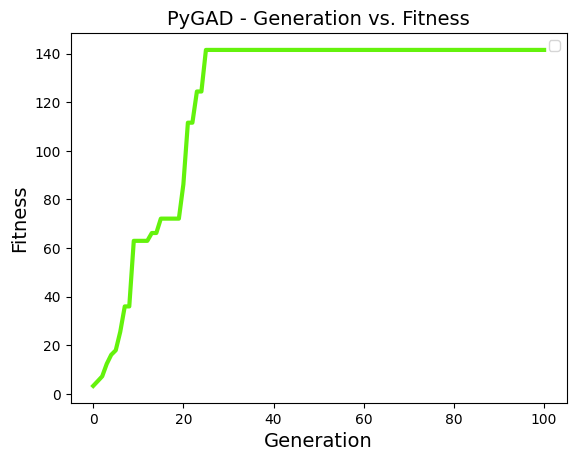

**************************************************
 optimal pattern in 16-weeks-cycle: [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1]
 total return of optimal pattern:   141.50


In [8]:
# performing GA-optimisation, plotting fittnes function and printing results
price_w_run_opt = price_w_original
ga_instance.run()
pos, strat, strat_idx = ga_instance.best_solution()
fig = ga_instance.plot_fitness()
print('**************************************************')
print(f' optimal pattern in 16-weeks-cycle: {pos.tolist()}')
print(f' total return of optimal pattern:   {strat:.2f}')

In [9]:
# plotting of optimized results and comparing to the original pattern
title = 'Equity Curve 16-weeks-cycle, GA-optimized vs. original pattern vs. Buy&Hold <br><br><sup>DAX [2000-2018] </sup>'

# calculations for optimized pattern
pos_optimized = pos
price_w_optimized = price_w_original.copy()
pos_weekly(price_w_optimized, pos_optimized, shift=0)
pnl_opt = pnl_calculation(price_w_optimized)
x11, x12, x13 = pnl_opt['pnl_b&h'][-1], pnl_opt['pnl_strategy'][-1], pnl_opt['pnl_strategy2'][-1]

# calculations for original pattern
pos_original = [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 1, 1, 1, -1]
shift_weeks = 12
price_w_original = price_w_original.copy()
pos_weekly(price_w_original, pos_original, shift_weeks)
pnl_orig = pnl_calculation(price_w_original)
x21, x22, x23 = pnl_orig['pnl_b&h'][-1], pnl_orig['pnl_strategy'][-1], pnl_orig['pnl_strategy2'][-1]

# plotting/printing
fig = go.Figure()
fig.add_trace(go.Scatter(x=pnl_opt.index, y=pnl_opt['pnl_strategy'], name='optimized pattern'))
fig.add_trace(go.Scatter(x=pnl_orig.index, y=pnl_orig['pnl_strategy'], name='original pattern'))
fig.add_trace(go.Scatter(x=pnl_opt.index, y=pnl_opt['pnl_b&h'], name='Buy & Hold'))
fig.update_layout(title=title)
fig.update_layout(autosize=False,width=800,height=400)
fig.update_layout(template = 'plotly_dark', xaxis_title="Date", yaxis_title='PnL')
fig.show()

print('**********************************************************************************************************')
print(f'Results (optimized pattern):  Buy and Hold:  {x11:.2f}  Strategy:  {x12:.2f}  Strategy2:  {x13:.2f}')
print(f'Results (original pattern):   Buy and Hold:  {x21:.2f}  Strategy:  {x22:.2f}  Strategy2:  {x23:.2f}')

**********************************************************************************************************
Results (optimized pattern):  Buy and Hold:  1.52  Strategy:  141.50  Strategy2:  6.46
Results (original pattern):   Buy and Hold:  1.52  Strategy:  22.74  Strategy2:  4.31


## 2.2 Extension to full period [2000-2024] but keeping the pattern from [2000-2018]

In [10]:
title = 'Equity Curve 16-weeks-cycle, GA-optimized vs. original pattern vs. Buy&Hold <br><br><sup>DAX [2000-2024] with parameters from [2000-2018] </sup>'

# calculations for optimized pattern
pos_optimized = pos
price_w_optimized = price_w.copy()
pos_weekly(price_w_optimized, pos_optimized, shift=0)
pnl_opt = pnl_calculation(price_w_optimized)
x11, x12, x13 = pnl_opt['pnl_b&h'][-1], pnl_opt['pnl_strategy'][-1], pnl_opt['pnl_strategy2'][-1]

# calculations for original pattern
pos_original = [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 1, 1, 1, -1]
shift_weeks = 12
price_w_original = price_w.copy()
pos_weekly(price_w_original, pos_original, shift_weeks)
pnl_orig = pnl_calculation(price_w_original)
x21, x22, x23 = pnl_orig['pnl_b&h'][-1], pnl_orig['pnl_strategy'][-1], pnl_orig['pnl_strategy2'][-1]

# plotting/printing
fig = go.Figure()
fig.add_trace(go.Scatter(x=pnl_opt.index, y=pnl_opt['pnl_strategy'], name='optimized pattern'))
fig.add_trace(go.Scatter(x=pnl_orig.index, y=pnl_orig['pnl_strategy'], name='original pattern'))
fig.add_trace(go.Scatter(x=pnl_opt.index, y=pnl_opt['pnl_b&h'], name='Buy & Hold'))
fig.update_layout(title=title)
fig.update_layout(autosize=False,width=800,height=400)
fig.update_layout(template = 'plotly_dark', xaxis_title="Date", yaxis_title='PnL')
fig.show()

print('**********************************************************************************************************')
print(f'Results (optimized pattern):  Buy and Hold:  {x11:.2f}  Strategy:  {x12:.2f}  Strategy2:  {x13:.2f}')
print(f'Results (original pattern):   Buy and Hold:  {x21:.2f}  Strategy:  {x22:.2f}  Strategy2:  {x23:.2f}')

**********************************************************************************************************
Results (optimized pattern):  Buy and Hold:  2.62  Strategy:  87.15  Strategy2:  6.10
Results (original pattern):   Buy and Hold:  2.62  Strategy:  31.26  Strategy2:  4.66


## 2.3 Trade Statistics 16 weeks cycle with GA optimized pattern

In [11]:
# simulation of real conditions (incl. fee) and calculation of statistics
start_equity = 10000
fee = 0.0025                                                  # 0,25% of the traded volume
fixed_fee = 4.9                                               # 4,90 EUR pro trade
trades_optimized = trading_journal(price_w_optimized)         # generation list of trades
trades_original = trading_journal(price_w_original)           # generation list of trades
print('*** optimized pattern ****************************************************************************************')
trade_key_parameters(trades_optimized)                                  # key parameter independent from start_equity
trade_key_parameters2(trades_optimized, start_equity, fee, fixed_fee)   # key parameter depending on start_equity
print("")
print('*** original pattern *****************************************************************************************')
trade_key_parameters(trades_original)                                  # key parameter independent from start_equity
trade_key_parameters2(trades_original, start_equity, fee, fixed_fee)   # key parameter depending on start_equity

*** optimized pattern ****************************************************************************************
**************************************************************************************************
total number of trades: 633    number of LONG trades:317   number of SHORT trades: 316
percent profitable: 57.35 %   profit_factor: 1.69
average trade profit: 0.81 %
largest loosing trade: -27.4457 %
**************************************************************************************************
Start Equity:  10,000.0    final equity (w/o fees):  858,385.8    final equity (incl. fees):  29,333.4 
Gross Profit: 848,385.8   = 8,483.86 %     Net Profit (considering fees): 19,333.4  = 193.33 % 

*** original pattern *****************************************************************************************
**************************************************************************************************
total number of trades: 317    number of LONG trades:80   number of SHORT trades

In [12]:
# real equity curves (w/o fee and incl fee)
eqs = real_equity_curve(price_w_optimized, start_equity, fee, fixed_fee)
fig = px.line(eqs, x=eqs.index, y=['value','value_wo_fees'])
title = 'Equity Curve for 16-week-cycle (GA-optimized pattern) with and without fee. Instrument: DAX [2000-2024]'
fig.update_layout(title=title, xaxis_title='Date', yaxis_title='Equity (EUR)')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=500)
fig.show()

end_value_wo_fee, end_value =  eqs['value_wo_fees'][-1], eqs['value'][-1]
print(f' Equity development (in EUR):  Start Value {start_equity:,.1f}    End Value (w/o fees): {end_value_wo_fee:,.1f}   End Value incl. fees: {end_value:,.1f}')

 Equity development (in EUR):  Start Value 10,000.0    End Value (w/o fees): 871,536.3   End Value incl. fees: 29,792.1


In [13]:
# distribution of trade-returns
fig = px.histogram(trades_optimized, x=['returns'], color='type', nbins= 40)
title = 'Distribution of Returns - 16 wks cycle, Instrument: DAX [2000-2024] <br><sup>modified strategy, optimized pattern </sup>'
fig.update_layout(title=title, xaxis_title='Date', yaxis_title='# occurence')
fig.update_layout(template = 'plotly_dark', autosize=False,width=800,height=500)
fig.show()
# Means of ALL/LONG/SHORT trades
m_all = trades_optimized['returns'].mean() * 100
m_long = trades_optimized[trades_optimized['type']=='LONG']['returns'].mean() * 100
m_short = trades_optimized[trades_optimized['type']=='SHORT']['returns'].mean() * 100
print('********************************************************************')
print(f'average return all trades: {m_all:.3f} %  average return LONG: {m_long:.3f} %  average return SHORT: {m_short:.3f} % ')

********************************************************************
average return all trades: 0.805 %  average return LONG: 1.062 %  average return SHORT: 0.548 % 


In [14]:
gantt = []
for i in range (len(trades_original)):
  task = 'original pattern'
  start = trades_original.loc[i, 'date_entry']
  end = trades_original.loc[i, 'date_exit']
  typ = trades_original.loc[i, 'type']
  x = dict(Task=task, Start=start, Finish=end, Resource=typ)
  gantt.append(x)
for i in range (len(trades_optimized)):
  task = 'optimized pattern'
  start = trades_optimized.loc[i, 'date_entry']
  end = trades_optimized.loc[i, 'date_exit']
  typ = trades_optimized.loc[i, 'type']
  x = dict(Task=task, Start=start, Finish=end, Resource=typ)
  gantt.append(x)


In [16]:
fig = px.timeline(gantt, x_start="Start", x_end="Finish", y="Task", color="Resource")
title = 'positions during the overall timeline (16-weeks-cycle), DAX [2000-2024] '
fig.update_layout(title=title, xaxis_title='Date')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1600, height=300)
fig.show()


In [17]:
# DrawDown
x1 = pnl_opt['pnl_strategy'] - pnl_opt['pnl_strategy'].expanding().max()
x2 = pnl_orig['pnl_strategy'] - pnl_orig['pnl_strategy'].expanding().max()
fig = go.Figure()
title = 'Underwater-Plot 16-weeks-cycle (optimized vs. original pattern) DAX [2000-2024] '
fig.update_layout(title=title)
fig.update_layout(autosize=False, width=1200, height=300)
fig.add_trace(go.Scatter(x=x1.index, y=x1, mode='none', fill='tozeroy', fillcolor='rgba(0, 0, 255, 0.3)', name='optimized pattern'))
fig.add_trace(go.Scatter(x=x2.index, y=x2, mode='none', fill='tozeroy', fillcolor='rgba(255, 255, 0, 0.2)', name='original pattern'))
fig.update_layout(template = 'plotly_dark', xaxis_title="Date", yaxis_title='drawdown')
fig.show()


In [ ]:
# export of results to excel file
with pd.ExcelWriter(r'/content/gdrive/MyDrive/Colab Notebooks/Weekly Pattern/16_weeks_cycle_optimized (data).xlsx') as writer:
     price.to_excel(writer, sheet_name="daily data")
     price_w_optimized.to_excel(writer, sheet_name="weekly data")
     pnl_optm.to_excel(writer, sheet_name="PnL_opt")

#3. Optimizing the weekly pattern within different N-week-cycles

*   brute-force looping through all cycles between 4w (= one month) and 52 weeks (= one year)
*   tradings times (first trading day of the week at 9:00 (=open)
*   GA via PyGAD



## 3.1. Calculations

In [18]:
# optimizing using the full period
price_w_run = price_w
# preparation of dataframe for storing results
results = pd.DataFrame(columns=['cycle', 'strat', 'pattern'])
# looping through various cycles
for cycle_length in tqdm(range(4,52)):
  ga_instance = pygad.GA(num_generations=120,
                       num_parents_mating=4,
                       fitness_func=opt_pattern1,
                       sol_per_pop=8,
                       num_genes=cycle_length,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)
  ga_instance.run()
  pos, strat, strat_idx = ga_instance.best_solution()
  print(f' cycle_length:  {cycle_length}     Strategy:    {strat:.2f}  Pattern:  {pos}')
  results.loc[len(results.index)] = [cycle_length, strat, pos]

  2%|▏         | 1/48 [00:02<01:47,  2.29s/it]

 cycle_length:  4     Strategy:    16.44  Pattern:  [ 1  1  1 -1]


  4%|▍         | 2/48 [00:04<01:36,  2.09s/it]

 cycle_length:  5     Strategy:    1.90  Pattern:  [1 1 0 1 0]


  6%|▋         | 3/48 [00:06<01:30,  2.01s/it]

 cycle_length:  6     Strategy:    4.65  Pattern:  [ 1  0 -1 -1  1 -1]


  8%|▊         | 4/48 [00:08<01:27,  1.99s/it]

 cycle_length:  7     Strategy:    2.82  Pattern:  [ 0  1 -1  1  1  1  1]


 10%|█         | 5/48 [00:10<01:27,  2.03s/it]

 cycle_length:  8     Strategy:    30.40  Pattern:  [ 1  1  1 -1  1  1 -1 -1]


 12%|█▎        | 6/48 [00:12<01:33,  2.23s/it]

 cycle_length:  9     Strategy:    6.05  Pattern:  [ 1  1  0  1  1  0 -1 -1 -1]


 15%|█▍        | 7/48 [00:15<01:38,  2.40s/it]

 cycle_length:  10     Strategy:    4.55  Pattern:  [ 1  0  1 -1  1  1  1 -1  1 -1]


 17%|█▋        | 8/48 [00:17<01:32,  2.31s/it]

 cycle_length:  11     Strategy:    21.94  Pattern:  [-1 -1  1  1  1  1  1 -1  1  0 -1]


 19%|█▉        | 9/48 [00:19<01:27,  2.24s/it]

 cycle_length:  12     Strategy:    19.35  Pattern:  [ 1  1 -1 -1  1  1  1 -1  0  1  1 -1]


 21%|██        | 10/48 [00:21<01:23,  2.21s/it]

 cycle_length:  13     Strategy:    14.88  Pattern:  [ 1  1 -1  1  1  1  0 -1 -1  1 -1  1  1]


 23%|██▎       | 11/48 [00:25<01:41,  2.74s/it]

 cycle_length:  14     Strategy:    7.59  Pattern:  [ 1  1  0 -1  0 -1  1 -1  0 -1  1  1  1 -1]


 25%|██▌       | 12/48 [00:32<02:16,  3.79s/it]

 cycle_length:  15     Strategy:    7.57  Pattern:  [ 1  1 -1  1  1 -1  1 -1  1  0  1 -1  1 -1 -1]


 27%|██▋       | 13/48 [00:36<02:15,  3.88s/it]

 cycle_length:  16     Strategy:    141.50  Pattern:  [ 1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1 -1]


 29%|██▉       | 14/48 [00:38<01:53,  3.34s/it]

 cycle_length:  17     Strategy:    15.50  Pattern:  [ 1  1 -1 -1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1]


 31%|███▏      | 15/48 [00:40<01:41,  3.07s/it]

 cycle_length:  18     Strategy:    18.69  Pattern:  [ 1  1 -1  1  1 -1  0 -1  1 -1  1  1  1  0  0 -1  1 -1]


 33%|███▎      | 16/48 [00:43<01:38,  3.08s/it]

 cycle_length:  19     Strategy:    13.36  Pattern:  [-1 -1  1 -1  1  1 -1  1  1  1  1  1 -1 -1  1  1  1  0 -1]


 35%|███▌      | 17/48 [00:45<01:26,  2.80s/it]

 cycle_length:  20     Strategy:    20.59  Pattern:  [ 1  1  1 -1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1]


 38%|███▊      | 18/48 [00:48<01:18,  2.60s/it]

 cycle_length:  21     Strategy:    34.41  Pattern:  [-1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1]


 40%|███▉      | 19/48 [00:50<01:11,  2.47s/it]

 cycle_length:  22     Strategy:    46.52  Pattern:  [-1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1  1  0  1  1  1 -1  0  1 -1]


 42%|████▏     | 20/48 [00:52<01:07,  2.40s/it]

 cycle_length:  23     Strategy:    22.34  Pattern:  [ 1  1  0 -1  1  1  1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1 -1  1  1  1]


 44%|████▍     | 21/48 [00:55<01:06,  2.45s/it]

 cycle_length:  24     Strategy:    45.57  Pattern:  [ 0  1  1 -1  1  1 -1  1  1  0  1 -1  1  1 -1 -1  1  1  1 -1 -1  1  1 -1]


 46%|████▌     | 22/48 [00:58<01:08,  2.62s/it]

 cycle_length:  25     Strategy:    35.64  Pattern:  [-1  0 -1  1  1  1 -1 -1  0 -1  1  0 -1  0 -1 -1  1  1 -1 -1 -1  1  0  1
  1]


 48%|████▊     | 23/48 [01:00<01:02,  2.52s/it]

 cycle_length:  26     Strategy:    44.29  Pattern:  [ 1  1 -1 -1  1 -1  1 -1 -1 -1 -1  0  1  1  1  1  1  1  1  0  0  0  1 -1
  0 -1]


 50%|█████     | 24/48 [01:02<00:58,  2.44s/it]

 cycle_length:  27     Strategy:    29.77  Pattern:  [ 1  1 -1  0  1  1 -1  0  1  1  1  1  1  1 -1  1  1 -1 -1  1  0  1  1  1
 -1 -1 -1]


 52%|█████▏    | 25/48 [01:04<00:54,  2.39s/it]

 cycle_length:  28     Strategy:    39.82  Pattern:  [ 1  1 -1 -1  0  1  1 -1  1 -1  1 -1  1  1  0 -1  1 -1  0 -1  1  0  0 -1
 -1  1  1 -1]


 54%|█████▍    | 26/48 [01:07<00:51,  2.35s/it]

 cycle_length:  29     Strategy:    41.67  Pattern:  [ 1 -1 -1  0  1  1  1 -1 -1  1  1  1 -1  0 -1  0 -1  1  1  1 -1  1 -1  1
 -1  1  1  1  1]


 56%|█████▋    | 27/48 [01:10<00:53,  2.53s/it]

 cycle_length:  30     Strategy:    15.71  Pattern:  [ 1  1 -1 -1  1 -1  0 -1  1 -1  1 -1  1 -1  1  0  1  1  1 -1 -1  0  1  1
  0  1  0  0 -1 -1]


 58%|█████▊    | 28/48 [01:12<00:51,  2.58s/it]

 cycle_length:  31     Strategy:    27.24  Pattern:  [-1  1 -1  1  1  0  1  1 -1  1  1  1  1 -1  1  0 -1 -1  1 -1  0  1 -1  1
  0 -1  1 -1 -1  0  1]


 60%|██████    | 29/48 [01:14<00:46,  2.47s/it]

 cycle_length:  32     Strategy:    124.33  Pattern:  [ 1  1  1 -1 -1 -1  1  1 -1  0  1 -1  0  0 -1 -1  1  1  1 -1  1  1  1  0
 -1 -1  1 -1  1  0 -1 -1]


 62%|██████▎   | 30/48 [01:17<00:43,  2.39s/it]

 cycle_length:  33     Strategy:    78.22  Pattern:  [-1  0  1  1  1  1  1  1  1  0 -1  0  1  1 -1  0  1  1  1  1 -1  1  0 -1
  1  1 -1  0 -1 -1 -1  1 -1]


 65%|██████▍   | 31/48 [01:19<00:39,  2.33s/it]

 cycle_length:  34     Strategy:    37.93  Pattern:  [ 1  1 -1  0  1  1  1 -1  1  1  1  0  0  1  1 -1  1 -1  1 -1 -1  0  0 -1
  1 -1 -1  1 -1 -1  1 -1  0 -1]


 67%|██████▋   | 32/48 [01:21<00:37,  2.34s/it]

 cycle_length:  35     Strategy:    41.43  Pattern:  [-1 -1 -1  1  1  1 -1  1  1 -1  1  0  1 -1  0  1  1 -1  0  1  1  0 -1 -1
  1  0  1  0  1  1  1  1  1 -1 -1]


 69%|██████▉   | 33/48 [01:24<00:39,  2.60s/it]

 cycle_length:  36     Strategy:    64.50  Pattern:  [ 1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  0  1 -1  0  1  1  1  1  1  1  1 -1
 -1 -1  1 -1  1  1  1  0  1 -1  1 -1]


 71%|███████   | 34/48 [01:27<00:35,  2.56s/it]

 cycle_length:  37     Strategy:    47.97  Pattern:  [-1  1  1  0  1  0 -1 -1  1 -1  1  1 -1 -1  0 -1  1 -1 -1 -1  1  1 -1  1
  1  0  1 -1 -1  1  1 -1  1  1  1  1  1]


 73%|███████▎  | 35/48 [01:29<00:31,  2.46s/it]

 cycle_length:  38     Strategy:    66.33  Pattern:  [-1 -1  1  0  1  1 -1 -1  1 -1  1 -1 -1  0  0  1  1  0  0  0  1  0 -1  1
  1  0  1  1  1  0  1  0 -1  1  1 -1  1 -1]


 75%|███████▌  | 36/48 [01:31<00:28,  2.39s/it]

 cycle_length:  39     Strategy:    102.19  Pattern:  [ 1  1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  0  0 -1  0  1 -1 -1  1  1 -1
 -1  1  1  1 -1  1 -1  1  1  1  0 -1 -1 -1 -1]


 77%|███████▋  | 37/48 [01:34<00:26,  2.37s/it]

 cycle_length:  40     Strategy:    90.59  Pattern:  [-1  1  1  0 -1  0 -1  1 -1  1  1 -1 -1  0  0  0  1 -1  1 -1  1  1  1 -1
  1  1  1 -1  1  0  1 -1  0  1 -1 -1  1 -1 -1  0]


 79%|███████▉  | 38/48 [01:36<00:24,  2.47s/it]

 cycle_length:  41     Strategy:    50.29  Pattern:  [ 0  1  0  0 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1  1  1
 -1 -1  0 -1  0  0 -1  1 -1  1 -1  0 -1 -1  1  1  0]


 81%|████████▏ | 39/48 [01:39<00:23,  2.60s/it]

 cycle_length:  42     Strategy:    81.15  Pattern:  [-1  1  0 -1 -1 -1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1
  1  1  1 -1  1  0  0  1 -1  1  1 -1 -1 -1  0 -1  1 -1]


 83%|████████▎ | 40/48 [01:42<00:20,  2.50s/it]

 cycle_length:  43     Strategy:    94.37  Pattern:  [-1  0 -1 -1 -1  1  1  1  1  0  1  1  1 -1  0  0  1  0  0  1 -1  1 -1 -1
  0  0  1  1  1 -1  1  0  0 -1  1 -1  1 -1  1  0  0 -1  1]


 85%|████████▌ | 41/48 [01:44<00:17,  2.43s/it]

 cycle_length:  44     Strategy:    94.50  Pattern:  [-1  1  1  1  0  1  0  0  1  0 -1 -1  1  0  1  1  1  1 -1 -1  1 -1  0 -1
  1  1 -1  1  1  0  1 -1  1  1  1  1 -1  1  0  1 -1  1 -1 -1]


 88%|████████▊ | 42/48 [01:46<00:14,  2.37s/it]

 cycle_length:  45     Strategy:    67.27  Pattern:  [ 1  0  1  1  1 -1 -1 -1  1 -1  1  1  1 -1  0 -1  1 -1  0  1 -1  1  1  1
  1  1  0  1  1 -1  0  1  1  1 -1  0  1  0 -1  1  0 -1  1  0 -1]


 90%|████████▉ | 43/48 [01:48<00:11,  2.34s/it]

 cycle_length:  46     Strategy:    55.54  Pattern:  [ 1  0  1 -1  1  1 -1  1  0  1 -1  1 -1  0  1  1  0 -1  0 -1  1 -1  1 -1
  0 -1 -1  0 -1  0 -1  1  0 -1  1  1 -1  1  0  1  0 -1 -1 -1  1 -1]


 92%|█████████▏| 44/48 [01:51<00:10,  2.56s/it]

 cycle_length:  47     Strategy:    63.20  Pattern:  [-1  1 -1  1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1 -1  0  1  1  0  0
 -1  1  1  0  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1  1]


 94%|█████████▍| 45/48 [01:54<00:07,  2.58s/it]

 cycle_length:  48     Strategy:    339.33  Pattern:  [ 1  1  0  0  1  1  1  0  1  0  0 -1  1 -1 -1 -1  1  1  1 -1 -1  0  1  1
 -1  1  1  0  0  1 -1 -1 -1  1  1 -1 -1  0  1  1 -1 -1  1 -1 -1  0  1 -1]


 96%|█████████▌| 46/48 [01:56<00:05,  2.50s/it]

 cycle_length:  49     Strategy:    74.80  Pattern:  [ 0  1  1  0  1  1  1  1  1  0  1  0 -1  0  0  1 -1  1 -1  1  1  1  0  1
  1  1  1 -1  1 -1 -1 -1  0  0 -1 -1  1  0  1  0  1  1  1  1 -1  1  0 -1
  1]


 98%|█████████▊| 47/48 [01:59<00:02,  2.44s/it]

 cycle_length:  50     Strategy:    90.81  Pattern:  [ 0  0 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  0  1 -1  1  1 -1  1 -1  1  0  0
  0 -1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1  1  0
  1  1]


100%|██████████| 48/48 [02:01<00:00,  2.53s/it]

 cycle_length:  51     Strategy:    31.03  Pattern:  [-1  1  1 -1  1  1  1  0 -1  1  1 -1 -1  1  1  0  0  1 -1 -1  1  1  1 -1
  1  1  0  1  1 -1  1  1 -1 -1  1 -1  0 -1  0  0  1 -1  1 -1 -1 -1  0  1
  0 -1  0]


In [19]:
fig = px.bar(results, x=results['cycle'], y=results['strat'])
fig.update_layout(title='optimized returns for various cycles')
fig.update_layout(template = 'plotly_dark', autosize=False,width=1400,height=400)
fig.add_hline(y=pnl_orig['pnl_b&h'][-1], line_dash='dot', line_color='green', annotation_text='Buy and Hold PnL', annotation_position='top left')
fig.update_layout(xaxis_title="cycle length [wks]", yaxis_title='PnL')

In [20]:
# selection of the best fits
best_fits = [16, 32, 48]
list_pos = results[results.cycle.isin(best_fits)]
pos_list = list(list_pos['pattern'])

In [21]:
# preparation for gantt-chart plot
gantt = []
for i in range(0, len(best_fits)):
  pos = pos_list[i].tolist()
  price_w1 = price_w.copy()
  pos_weekly(price_w1, pos, shift=0)
  trades = trading_journal(price_w1)
  task = f' cl = {best_fits[i]}'
  for j in range (len(trades)):
    start = trades.loc[j, 'date_entry']
    end = trades.loc[j, 'date_exit']
    typ = trades.loc[j, 'type']
    x = dict(Task=task, Start=start, Finish=end, Resource=typ)
    gantt.append(x)

In [22]:
fig = px.timeline(gantt, x_start="Start", x_end="Finish", y="Task", color="Resource")
title = 'positions (=patterns) during selected N-weeks cycles, DAX [2000-2024] '
fig.update_layout(title=title, xaxis_title='Date', yaxis_title = ' cyclelength')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1600, height=300)
fig.show()

##3.2 Trade Statistics (for best fits only)

In [23]:
# simulation of real conditions (incl. fee) and calculation of statistics
startequity = 10000
fee = 0.0025                                                  # 0,25% of the traded volume
fixed_fee = 4.9                                               # 4,90 EUR pro trade

for i in range(0, len(best_fits)):
  start_equity = startequity

  pos = pos_list[i].tolist()
  price_w1 = price_w.copy()
  pos_weekly(price_w1, pos, shift=0)
  trades = trading_journal(price_w1)
  print(f'*** results for optimized pattern in {best_fits[i]}-weeks-cycle ************************************************')
  trade_key_parameters(trades)                                  # key parameter independent from start_equity
  trade_key_parameters2(trades, start_equity, fee, fixed_fee)   # key parameter depending on start_equity
  print(' ')


*** results for optimized pattern in 16-weeks-cycle ************************************************
**************************************************************************************************
total number of trades: 633    number of LONG trades:317   number of SHORT trades: 316
percent profitable: 57.35 %   profit_factor: 1.69
average trade profit: 0.81 %
largest loosing trade: -27.4457 %
**************************************************************************************************
Start Equity:  10,000.0    final equity (w/o fees):  858,385.8    final equity (incl. fees):  29,333.4 
Gross Profit: 848,385.8   = 8,483.86 %     Net Profit (considering fees): 19,333.4  = 193.33 % 
 
*** results for optimized pattern in 32-weeks-cycle ************************************************
**************************************************************************************************
total number of trades: 593    number of LONG trades:277   number of SHORT trades: 316
percent prof